In [1]:
from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

import pandas as pd
import numpy as np

import pmlb
import matplotlib.pyplot as plt

In [2]:
datasets = [
    '229_pwLinear',
    '529_pollen',
    '210_cloud',
    '503_wind',
    '560_bodyfat',
]

In [3]:
dataset_name = '560_bodyfat'
df = pmlb.fetch_data(dataset_name)
print(df.shape)

(252, 15)


In [4]:
features = infer_feature_attributes(df)

In [5]:
trainee = Trainee(features=features)
trainee.train(df)

context_features = features.get_names(without=['target'])
trainee.analyze(action_features=['target'], context_features=context_features, targeted_model='single_targeted')



The following parameters from configuration file will override the Amalgam parameters set in the code: {'library_path', 'trace'}


In [6]:
cases = trainee.get_cases(features=['.session', '.session_training_index', 'target'])
case_indices = cases[['.session', '.session_training_index']].values.tolist()

C:\Users\MikeResnick\base\lib\site-packages\howso\direct\client.py:3337: UserWarning: Calling get_cases without session id does not guarantee case order.
  warnings.warn("Calling get_cases without session id does not "


In [7]:
preds = trainee.react(
    case_indices=case_indices,
    preserve_feature_values=context_features,
    leave_case_out=True,
    context_features=context_features,
    action_features=['target'], 
    details={'feature_residuals': True}
)


In [11]:
predictions = preds['action']['target'].to_numpy() 
true_values = cases['target'].to_numpy()

prediction_residuals = np.abs(predictions - true_values)

local_residuals = np.array([x['target'] for x in preds['explanation']['feature_residuals']]) # * buddies_list

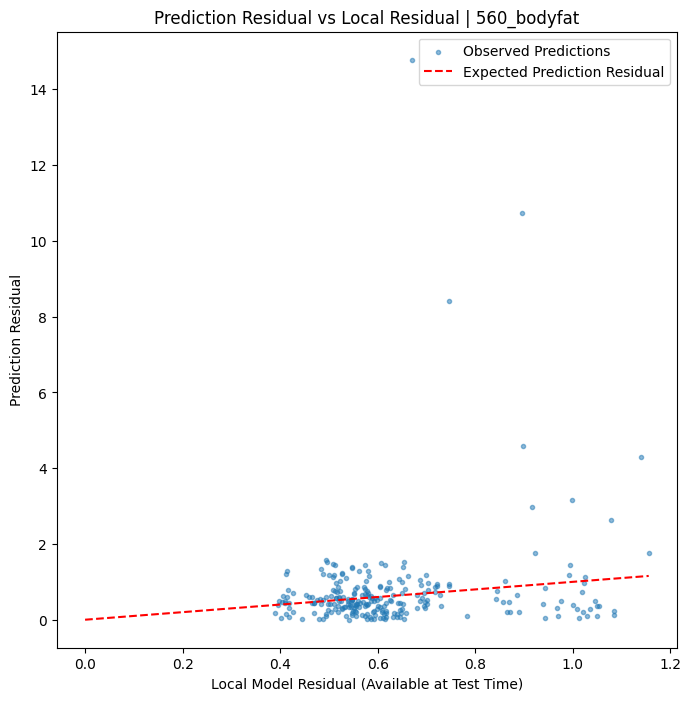

In [12]:
sample_ratio = 1.0
sample_idxs = np.random.choice(list(range(0, len(prediction_residuals))), size=int(len(prediction_residuals)*sample_ratio), replace=False)

plt.figure(figsize=(8, 8))
#plt.scatter(local_residuals[sample_idxs], prediction_residuals[sample_idxs], alpha=0.5, label='Observed Predictions', s=9.0)
plt.scatter(local_residuals, prediction_residuals, alpha=0.5, label='Observed Predictions', s=9.0)
plt.xlabel('Local Model Residual (Available at Test Time)')
plt.ylabel('Prediction Residual')
plt.title(f'Prediction Residual vs Local Residual | {dataset_name}')

highest_value = min(max(local_residuals[sample_idxs]), max(prediction_residuals[sample_idxs]))
plt.plot([0, highest_value], [0, highest_value], c='r', linestyle='--', label='Expected Prediction Residual')
plt.legend()

In [13]:
(prediction_residuals > local_residuals).sum() / local_residuals.shape[0]

0.4246031746031746

In [14]:
residual_diffs = abs(local_residuals - prediction_residuals)
((residual_diffs / local_residuals) < 1.0).sum() / local_residuals.shape[0]

0.876984126984127

In [15]:
from scipy import stats
from sklearn.metrics import r2_score
stats.spearmanr(local_residuals, prediction_residuals).correlation

0.05701042995344053

In [16]:
r2_score(prediction_residuals, local_residuals)

0.02063249815639201

In [18]:
# Run the full set of code and create and save the plot as well as print the ~metrics for a given dataset string
def run_dataset(dataset: str):
    print(f"======== RUNNING: {dataset} ========")
    df = pmlb.fetch_data(dataset)
    features = infer_feature_attributes(df)

    trainee = Trainee(features=features)
    trainee.train(df)

    context_features = features.get_names(without=['target'])
    trainee.analyze(action_features=['target'], context_features=context_features, targeted_model='single_targeted')
    trainee.react_into_trainee(action_feature='target', residuals=True)

    cases = trainee.get_cases(features=['.session', '.session_training_index', 'target'], session=trainee.get_sessions()[0]['id'])
    case_indices = cases[['.session', '.session_training_index']].values.tolist()
    
    preds = trainee.react(
        case_indices=case_indices,
        preserve_feature_values=context_features,
        leave_case_out=True,
        context_features=context_features,
        action_features=['target'], 
        details={'feature_residuals': True}
    )

    predictions = preds['action']['target'].to_numpy()
    true_values = cases['target'].to_numpy()

    prediction_residuals = np.abs(predictions - true_values)

    local_residuals = np.array([x['target'] for x in preds['explanation']['feature_residuals']])

    sample_ratio = 1.0
    sample_idxs = np.random.choice(list(range(0, len(prediction_residuals))), size=int(len(prediction_residuals)*sample_ratio), replace=False)

    plt.figure(figsize=(8, 8))
    plt.scatter(local_residuals[sample_idxs], prediction_residuals[sample_idxs], alpha=0.5, label='Observed Predictions', s=9.0)
    plt.xlabel('Local Model Residual (Available at Test Time)')
    plt.ylabel('Prediction Residual')
    plt.title(f'Prediction Residual vs Local Residual | {dataset}')

    highest_value = min(max(local_residuals[sample_idxs]), max(prediction_residuals[sample_idxs]))
    plt.plot([0, highest_value], [0, highest_value], c='r', linestyle='--', label='Expected Prediction Residual')
    plt.legend()
    plt.savefig(f'results/{dataset}.png')

    print(f"Percent of predictions with higher observed residual than expected: {(prediction_residuals > local_residuals).sum() / local_residuals.shape[0]}")
    print(f"Spearman coeff: {stats.spearmanr(local_residuals, prediction_residuals).correlation}")
    print(f"R^2 score: {r2_score(prediction_residuals, local_residuals)}")

======== RUNNING: 229_pwLinear ========
Percent of predictions with higher observed residual than expected: 0.41
Spearman coeff: 0.045928148203705096
R^2 score: -0.008927977731582715
======== RUNNING: 529_pollen ========
Percent of predictions with higher observed residual than expected: 0.4352910602910603
Spearman coeff: 0.12300633141532945
R^2 score: 0.015872752813120283
======== RUNNING: 210_cloud ========
Percent of predictions with higher observed residual than expected: 0.48148148148148145
Spearman coeff: 0.43158325950060494
R^2 score: 0.18640764942334087
======== RUNNING: 503_wind ========
Percent of predictions with higher observed residual than expected: 0.4326133252205659
Spearman coeff: 0.15465953017303372
R^2 score: 0.040847626912239754
======== RUNNING: 560_bodyfat ========
Percent of predictions with higher observed residual than expected: 0.4246031746031746
Spearman coeff: 0.08986902006129445
R^2 score: 0.031169435784055954


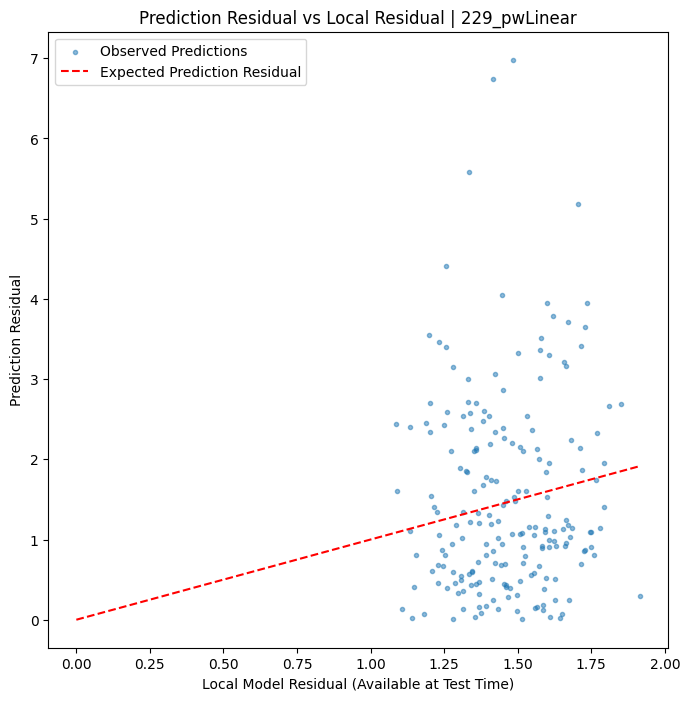

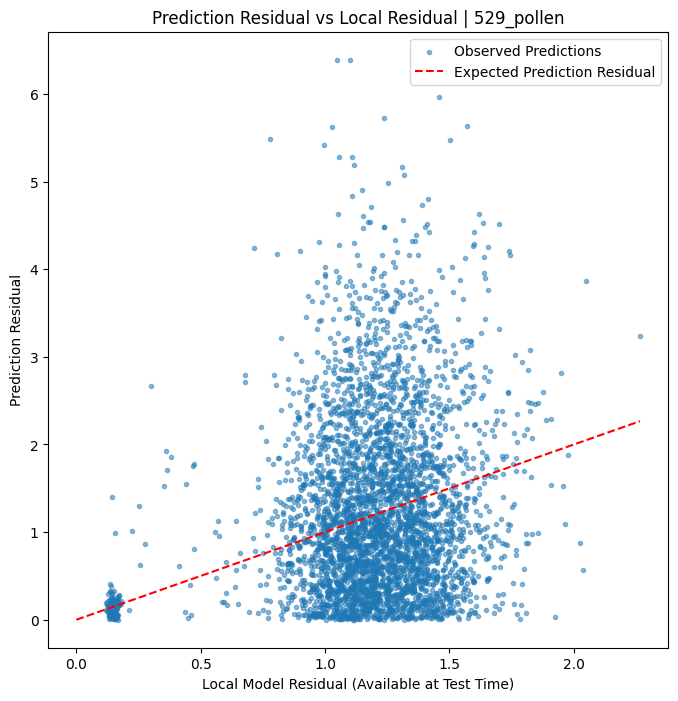

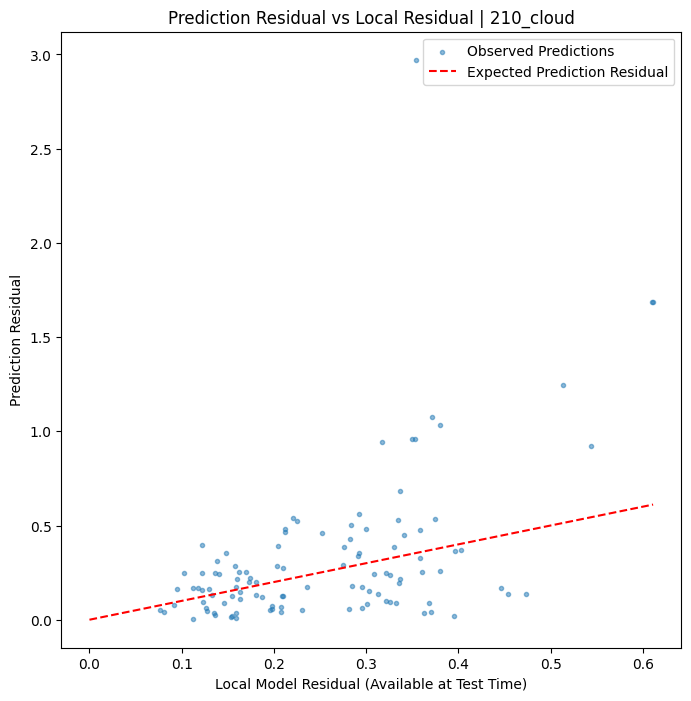

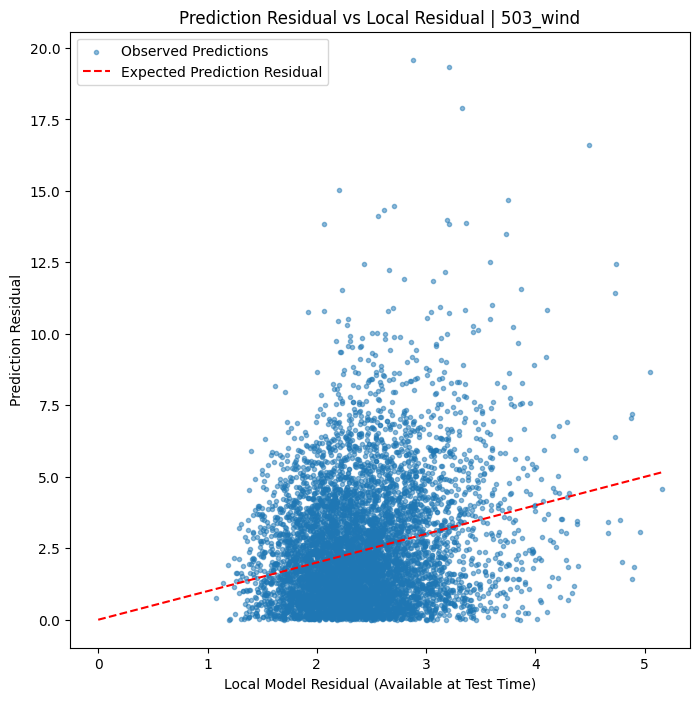

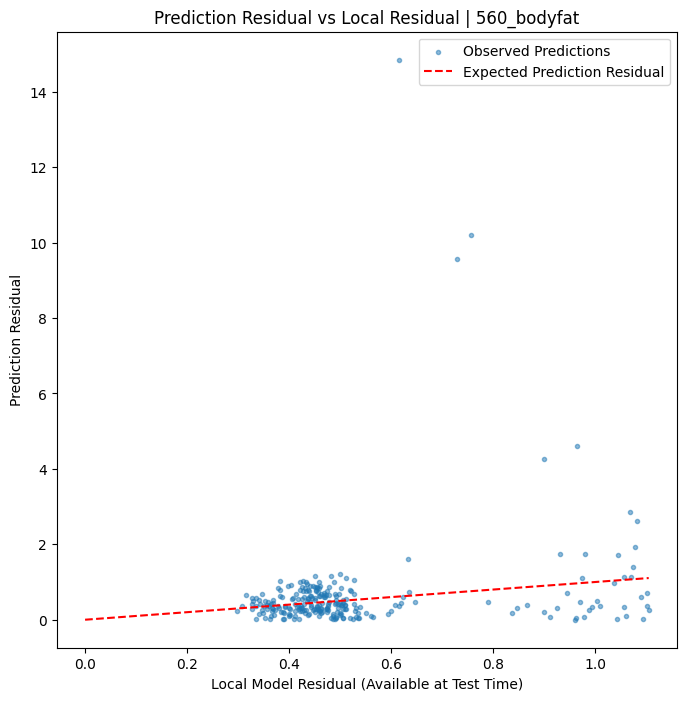

In [19]:
for dataset_str in datasets:
    run_dataset(dataset_str)